# PyTorch CNN for Yeast Promoters

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from itertools import combinations
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from random import shuffle
from time import time

import copy
import sys

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Data Preprocessing
Using one-hot encoding functions provided by original code to convert DNA base pairs to vectors

In [3]:
DNA = ['A','C','G','T']
def one_hot_encode(sequences):
  dna_dict = {}
  for i,q in enumerate(DNA):
      dna_dict[q] = i
  ans = [_encode_one(q, dna_dict) for q in tqdm(sequences, desc='one-hot encoding sequences', file=sys.stdout, leave=True, position=0)]
  return np.squeeze(ans)

def _encode_one(seq, dna_dict):
  ans = np.zeros(shape=(len(seq), len(DNA)), dtype = 'int')
  for i,q in enumerate(seq):
      ans[i, dna_dict[q]] = 1
  return ans

In [4]:
root = '/content/drive/MyDrive/yeast/'
input_file = 'data/means_trainable_joined.csv'
zev_file = 'data/means_trainable_ZEV.csv' # If training using only ZEV promoters
gpd_file = 'data/means_trainable_GPD.csv' # If training using only PGD promoters

# Reading data and splitting into train/validation/test
data = pd.read_csv(input_file,sep=',')
data.head()

,Seq,Strength_A,Strength_B
0,TACGTAAATAATTAATAGTAGTGACAAAAAAAAACTACGGACCGTA...,-0.020,-0.020
1,TACGTAAATAATTAATAGTAGTGACAAAAAAAAATATTCGATGATT...,0.044,0.044
2,TACGTAAATAATTAATAGTAGTGACAAAAAAAACGTGTCTGGCGCG...,0.142,0.142
3,TACGTAAATAATTAATAGTAGTGACAAAAAAAACTACCACCTATCG...,-0.252,-0.252
4,TACGTAAATAATTAATAGTAGTGACAAAAAAACAAATTGACGGGCT...,0.164,0.164


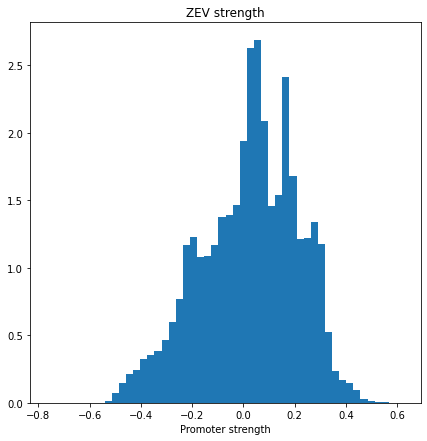

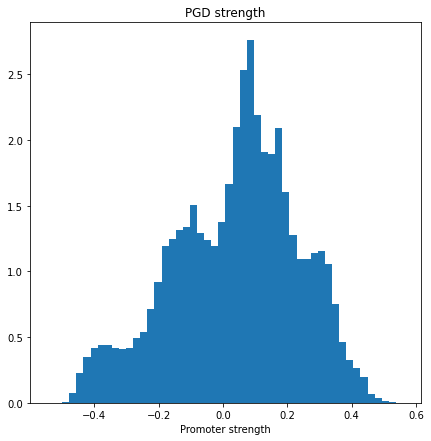

In [13]:
def plot_histogram(labels, title):
  fig = plt.figure(figsize=(7,7))

  ax = fig.add_subplot(111)
  plt.xlabel('Promoter strength')
  plt.title(title)
  plt.hist(labels,50,density=True,)

plot_histogram(data['Strength_A'].iloc[675300:], 'ZEV strength')
plot_histogram(data['Strength_A'].iloc[:675300], 'PGD strength')

In [5]:
def to_tensor(array):
  """
    Simple function to convert numpy arrays to the appropriate tensor
  """
  return torch.as_tensor(array, dtype=torch.float, device=torch.device(device))

def pad(df, left_pad, right_pad):
  """
    Padding function to pad sequences to the left and right with a given string of bases
    (Not needed if using joined dataset as sequences are pre-padded to equal length)
  """
  return [left_pad + seq + right_pad for seq in df]

def split_indices(df, test_frac=0.1, val_frac=0.1):
  """
    This function will provide the respective indices required to split the original dataset into
    PGD and ZEV promoters and then those further into training/validation/test splits
  """
  pgd_indices = df[df['Strength_A'] == df['Strength_B']].index.values
  zev_indices = df[df['Strength_A'] != df['Strength_B']].index.values

  test_size_PGD = np.floor(len(pgd_indices)*test_frac).astype(int)
  val_size_PGD = np.floor(len(pgd_indices)*val_frac).astype(int)

  test_size_ZEV = np.floor(len(zev_indices)*test_frac).astype(int)
  val_size_ZEV = np.floor(len(zev_indices)*val_frac).astype(int)

  remainderPGD, testPGD = train_test_split(pgd_indices, test_size=test_size_PGD, random_state=40)
  trainPGD, valPGD = train_test_split(remainderPGD, test_size=val_size_PGD, random_state=40)

  remainderZEV, testZEV = train_test_split(zev_indices, test_size=test_size_ZEV, random_state=40)
  trainZEV, valZEV = train_test_split(remainderZEV, test_size=val_size_ZEV, random_state=40)

  return trainPGD, valPGD, testPGD, trainZEV, valZEV, testZEV

In [6]:
# Determine indices to split data with
train_PGD, val_PGD, test_PGD, train_ZEV, val_ZEV, test_ZEV = split_indices(data)

# Combining PGD and ZEV promoters for training
joined = True
if joined:
  trainX = np.concatenate((one_hot_encode(data['Seq'].iloc[train_PGD]), one_hot_encode(data['Seq'].iloc[train_ZEV])))
  trainy = np.concatenate((data['Strength_A'].iloc[train_PGD].values, data['Strength_A'].iloc[train_ZEV].values))
else:
  trainX = one_hot_encode(data['Seq'].iloc[train_PGD]
  trainy = data['Strength_A'].iloc[train_PGD].values

print(f'Training data shape: {trainX.shape}')
print(f'Training examples: {len(trainX)} \nValidation examples: {len(val_PGD)} (PGD) {len(val_ZEV)} (ZEV) \nTest Examples: {len(test_PGD)} (PGD) {len(test_ZEV)} (ZEV)')

one-hot encoding sequences: 100%|██████████| 261667/261667 [00:18<00:00, 14524.14it/s]
Training data shape: (801798, 363, 4)
Training examples: 801798 
Validation examples: 67516 (PGD) 32708 (ZEV) 
Test Examples: 67516 (PGD) 32708 (ZEV)


### Creating PyTorch datasets and dataloaders

In [7]:
class PromoterSequences(Dataset):
  def __init__(self, data):
    """
      Pass the input dataset as a tuple of arrays (X, y)
    """
    self.data = data
    self.shape = data[0].shape

  def __len__(self):
    return len(self.data[0])

  def shape(self):
    return self.shape.item()

  def __getitem__(self,idx):
    sequence = self.data[0][idx]
    label = self.data[1][idx]
    return (sequence, label)

### Validation data

In [14]:
# Need to create separate dataloaders for PGD and ZEV promoters for validation
val_dataset_PGD = PromoterSequences((one_hot_encode(data['Seq'].iloc[val_PGD]), data['Strength_A'].iloc[val_PGD].values))
val_loader_PGD = DataLoader(val_dataset_PGD, batch_size=128, shuffle=True)

val_dataset_ZEV = PromoterSequences((one_hot_encode(data['Seq'].iloc[val_ZEV]), data['Strength_A'].iloc[val_ZEV].values))
val_loader_ZEV = DataLoader(val_dataset_ZEV, batch_size=128, shuffle=True)

one-hot encoding sequences: 100%|██████████| 32708/32708 [00:02<00:00, 14857.49it/s]


# Creating the model

In [9]:
class ConvNet(nn.Module):
  def __init__(self, in_c=1):
    super(ConvNet, self).__init__()
    FILTERS = 128

    self.conv_block1 = nn.Sequential(
        nn.Conv1d(in_c, FILTERS, kernel_size=8,stride=1,padding=(4,)),
        nn.BatchNorm1d(FILTERS),
        nn.ReLU(),
        nn.MaxPool1d(2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv1d(FILTERS, FILTERS, kernel_size=8,stride=1,padding=(4,)),
        nn.BatchNorm1d(FILTERS),
        nn.ReLU(),
        nn.MaxPool1d(2)
    )
    self.dense = nn.Sequential(
        nn.Flatten(),
        nn.Linear(FILTERS, FILTERS),
        nn.BatchNorm1d(FILTERS),
        nn.ReLU()  
    )
    self.output = nn.Linear(FILTERS, 1)
    
  def forward(self, x):

    x = self.conv_block1(x) # 6 convolutional layers
    x = self.conv_block2(x)
    x = self.conv_block2(x)
    x = self.conv_block2(x)
    x = self.conv_block2(x)
    x = self.conv_block2(x)

    x = self.dense(self.dense(x)) # 2 dense layers
    x = self.output(x)

    return x

SHIFT = 8 # amount to shift each sequence by
in_c = trainX.shape[1] - SHIFT + 1 # number of input channels (length of each sliding window over a sequence)
model = ConvNet(in_c)
model.to(device)
print('Model loaded.')

Model loaded.


### Custom generator for the training
Since it is hard to implement dynamic loading and data augmentation in PyTorch, the original code's batch generator is copied. This function will generate, as needed, 'shifted' sequences.

For example, if we have an input sequence `AGTCAGTC` and our shift is 4 we can generate 4 different sub-sequences from this one sequence:
`[AGTCA, GTCAG, TCAGT, CAGTC]`

In [10]:
class shifting_batch_generator():
  def __init__(self, dataset_X, dataset_y, batch_size, shift):
    self.dataset_X = dataset_X
    self.dataset_y = dataset_y
    self.batch_size = batch_size
    self.shift = shift
    self.window_size = dataset_X.shape[1] - shift + 1
    tuple_gen = ((p,q) for p in range(self.dataset_X.shape[0]) for q in range(self.shift))
    self.tuples = [i for i in tuple_gen]
    self._regen_tuples()

  def _regen_tuples(self):
    self.curr_tuples = copy.copy(self.tuples)
    shuffle(self.curr_tuples)

  def __len__(self):
    return self.dataset_X.shape[0]

  def _get_batch(self):
    X_out = []
    y_out = []
    for i in range(self.batch_size):
      if len(self.curr_tuples) == 0:
        self._regen_tuples()
      sample_id, offset = self.curr_tuples.pop()
      X_out.append(self.dataset_X[sample_id,offset:offset+self.window_size,:])
      y_out.append(self.dataset_y[sample_id])

    return (np.stack(X_out,0), np.stack(y_out,0))

  def iter(self):
    while True:
      yield self._get_batch()

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, steps_per_epoch, log, epoch):
  """
    This training loop will take in the custom shifting batch generator to load the data with
    Training is done with a joined dataset (so each batch may or may not include both PGD and ZEV promoters)
    It will train 1 epoch

    Args:
      dataloader - the shifting batch generator
      steps_per_epoch - dataloader is an infinite generator, so need to specify when 1 epoch is finished
      log - log lists to add updates to
  """
  size = len(dataloader)
  initial_time = time()
  batch_loss = 0

  model.train()
  for batch, (X, y) in tqdm(enumerate(dataloader.iter()), file=sys.stdout, leave=True, position=0, total=int(steps_per_epoch)): 
    X, y = to_tensor(X), to_tensor(np.expand_dims(y,1))
    
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_loss += loss.item()

    if batch == steps_per_epoch:
      break

  batch_loss /= batch
  log.append([epoch, batch_loss])
  print(f" average loss: {batch_loss:>5f}")

def test_loop(dataloader, model, loss_fn, log=[], epoch=1, name='ZEV'):
  """
    The test loop performs inference on the validation or test data
    This must be done on PGD and ZEV promoters separately
  """
  size = len(dataloader.dataset)
  test_loss, preds, true = 0, [], []

  model.eval()
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      X, y = to_tensor(X), to_tensor(np.expand_dims(y,1))

      pred = model(X[:][:,0:X.shape[1]-SHIFT+1]) # Validation and test data are not shifted, so need to shorten each sequence to the correct length
      test_loss += loss_fn(pred, y).item()

      preds = np.append(preds, pred.cpu().detach().numpy())
      true = np.append(true, y.cpu().detach().numpy())

  test_loss /= batch
  score = r2_score(true, preds)
  log.append([epoch, test_loss, score])
  print(f"\n{name} Validation Error: \n Avg loss: {test_loss:>8f}, R2: {score:.3f}")

  return test_loss

def train_eval(model, )

### Model training and validation

In [35]:
learning_rate = 1e-5
epochs = 100

batch_size = 128
steps_per_epoch = np.ceil(SHIFT*trainX.shape[0]/batch_size).astype(int)

gen_train = shifting_batch_generator(trainX, trainy, batch_size, SHIFT)

# val_log_PGD = []
# val_log_ZEV = []
# train_log = []
loss_fn = nn.SmoothL1Loss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.8)
model_name = root+'models/combined/model_128_AB/model_128_AB'

for t in range(26, epochs):
  print(f"Epoch {t+1}\n-------------------------------")

  train_loop(gen_train, model, loss_fn, optimizer, steps_per_epoch, train_log, t)
  val_loss_PGD = test_loop(val_loader_PGD, model, loss_fn, val_log_PGD, t, 'PGD')
  val_loss_ZEV = test_loop(val_loader_ZEV, model, loss_fn, val_log_ZEV, t, 'ZEV')

  # LR scheduler
  scheduler.step(val_loss_PGD + val_loss_ZEV)

  # Model and log saving
  torch.save(model, model_name'.pth')
  np.save(model_name + '_val_log_pgd.npy',val_log_PGD)
  np.save(model_name + '_val_log_zev.npy',val_log_ZEV)
  np.save(model_name + '_train_log.npy',train_log)
print("Done!")

Epoch 27
-------------------------------
100%|█████████▉| 50109/50113 [06:38<00:00, 125.54it/s] average loss: 0.009392

PGD Validation Error: 
 Avg loss: 0.019320, R2: -0.014

ZEV Validation Error: 
 Avg loss: 0.018308, R2: -0.016
Epoch 28
-------------------------------
100%|█████████▉| 50106/50113 [06:40<00:00, 121.45it/s] average loss: 0.009383

PGD Validation Error: 
 Avg loss: 0.019790, R2: -0.038

ZEV Validation Error: 
 Avg loss: 0.017350, R2: 0.038
Epoch 29
-------------------------------
100%|█████████▉| 50108/50113 [06:37<00:00, 125.76it/s] average loss: 0.009374

PGD Validation Error: 
 Avg loss: 0.021259, R2: -0.115

ZEV Validation Error: 
 Avg loss: 0.019674, R2: -0.090
Epoch 30
-------------------------------
 19%|█▊        | 9324/50113 [01:14<05:24, 125.56it/s]

KeyboardInterrupt: ignored

# Visualisation
After model training, the predictions of the model can be visualised and so can the training curves

In [ ]:
# Load model for inference
model = torch.load('/content/drive/MyDrive/yeast/models/combined/model_128.pth')

In [36]:
def plot_learning_curve(train_log_file, val_log_file, title):
  """
    This function will plot the learning curves for training a model
    Only training loss, validation loss and validation R2 is recorded
  """
  train_log = np.load(train_log_file).T
  val_log = np.load(val_log_file).T

  fig, (loss, score) = plt.subplots(1,2)
  fig.set_size_inches(9,4)

  loss.plot(train_log[0], train_log[1], label='Training loss')
  loss.plot(val_log[0], val_log[1], label='Validation loss')
  loss.set_xlabel('Epoch')
  loss.set_ylabel('Huber loss')
  loss.set_title('Training curve for '+title+' promoters')
  loss.legend()

  score.plot(val_log[0], val_log[2], label='Validation R^2')
  score.set_xlabel('Epoch')
  score.set_ylabel('R^2 Score')
  score.legend()
  score.set_title('Validation R2 score for '+title+' promoters')
  plt.show()

def plot_predictions(X, y, model, title):
  """
    Creates a scatter plot in the style of the yeast paper, with an R2 score to accompany it
  """
  model.eval()
  true_labels = y
  pred_labels = np.squeeze(model(to_tensor(X[:][:,0:trainX.shape[1]-SHIFT+1])).cpu().detach().numpy())

  # Calculating density
  xy = np.vstack([true_labels,pred_labels])
  z = gaussian_kde(xy)(xy)

  # Sort so that green is on top
  idx = z.argsort()
  x, y, z = true_labels[idx], pred_labels[idx], z[idx]

  # Plotting
  range = np.ptp(true_labels)*0.1
  left_lim = min(np.min(pred_labels), np.min(true_labels)) - range
  right_lim = max(np.max(pred_labels), np.max(true_labels)) + range

  fig = plt.figure(figsize=(4,4))

  ax = fig.add_subplot(111)
  plt.scatter(x,y, s=30, alpha=0.3, c=z, marker='.')

  # Perfect fit line
  ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black',ls='--',alpha=0.5)

  ax.annotate(f'$R^2 = {r2_score(true_labels, pred_labels).round(3)}$',(0.83,0.05),xycoords='axes fraction')
  ax.set_aspect('equal', 'box')
  ax.set_xlim(left_lim, right_lim)
  ax.set_ylim(left_lim, right_lim)

  plt.xlabel('true value')
  plt.ylabel('predicted value')
  plt.title('CNN predictions for '+title+' promoters')
  # plt.savefig('/content/drive/MyDrive/yeast/models/induced/induced_model.png')
  plt.show()

In [37]:
# Generate random indices to do the visualisation with
sample_PGD = np.random.randint(len(valX_PGD), size=6000)
sample_ZEV = np.random.randint(len(valX_ZEV), size=6000)

valX_PGD = one_hot_encode(data['Seq'].iloc[val_PGD].iloc[sample_PGD])
valy_PGD = data['Strength_A'].iloc[val_PGD].values[sample_PGD]

valX_ZEV = one_hot_encode(data['Seq'].iloc[val_ZEV].iloc[sample_ZEV])
valy_ZEV = data['Strength_A'].iloc[val_ZEV].values[sample_ZEV]

one-hot encoding sequences: 100%|██████████| 6000/6000 [00:00<00:00, 12964.60it/s]


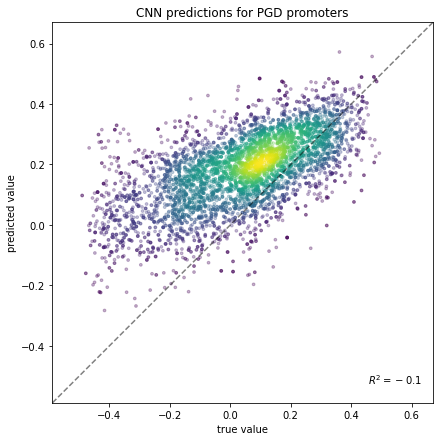

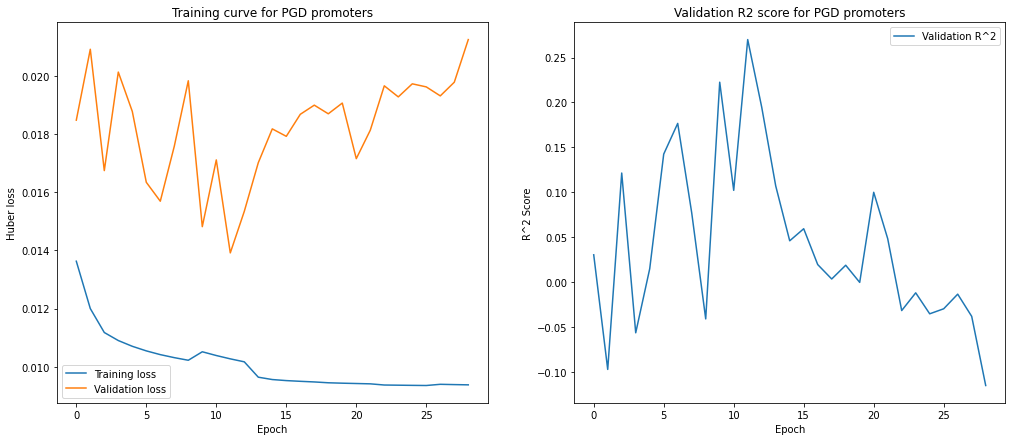

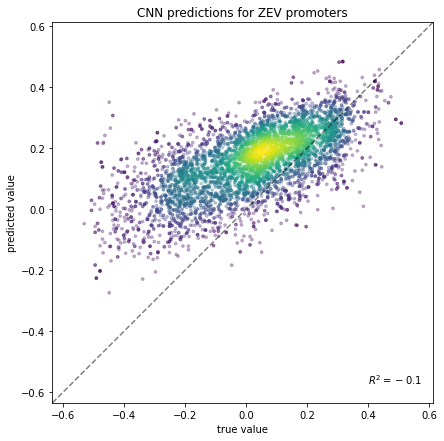

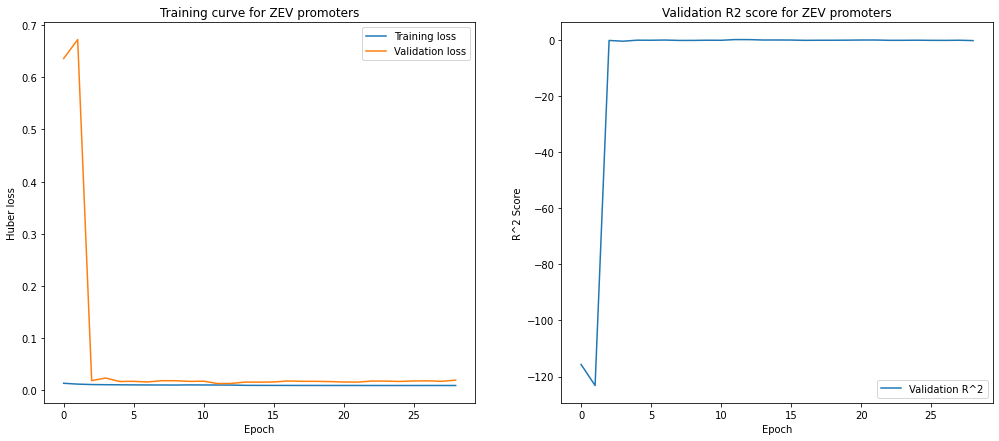

In [38]:
plot_predictions(valX_PGD, valy_PGD, model, 'PGD')
plot_learning_curve('/content/drive/MyDrive/yeast/models/combined/train_log_128_A.npy', '/content/drive/MyDrive/yeast/models/combined/val_log_128_A_pgd.npy', 'PGD')

plot_predictions(valX_ZEV, valy_ZEV, model, 'ZEV')
plot_learning_curve('/content/drive/MyDrive/yeast/models/combined/train_log_128_A.npy', '/content/drive/MyDrive/yeast/models/combined/val_log_128_A_zev.npy', 'ZEV')

# PyTorch CNN with DNABERT Embedding
First we need to load in the pre-trained and fine-tuned DNABERT model. This includes importing the actual model, the DNA tokenizer and the configuration file specifying parameters such as `num_labels`, `hidden_size` etc.

In [ ]:
from transformers import BertForSequenceClassification, BertConfig

def seq2kmer(seq, k):
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmers

In [ ]:
# Determine indices to split data with
train_PGD, val_PGD, test_PGD, train_ZEV, val_ZEV, test_ZEV = split_indices(data)

# trainX_kmer_pgd = data['Seq'].iloc[train_PGD].apply(lambda x: seq2kmer(x, 6)).values
# trainy_pgd = data['Strength_A'].iloc[train_PGD].values

trainX_kmer_zev = data['Seq'].iloc[train_ZEV].apply(lambda x: seq2kmer(x, 6)).values
trainy_zev = data['Strength_B'].iloc[train_ZEV].values

valX_kmer_zev = data['Seq'].iloc[val_ZEV].apply(lambda x: seq2kmer(x, 6)).values
valy_zev = data['Strength_B'].iloc[val_ZEV].values

In [ ]:
class PromoterTokenizer(Dataset):
  def __init__(self, data, tokenizer):
    """
      Pass the input dataset as a tuple of arrays (X, y)
    """
    self.data = data
    self.shape = data[0].shape
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.data[0])

  def shape(self):
    return self.shape.item()

  def __getitem__(self,idx):
    sequence = tokenizer(self.data[0][idx])
    label = self.data[1][idx]
    return (sequence, label)

### Creating dataloaders

In [ ]:
train_dataset_kmer_ZEV = PromoterSequences((trainX_kmer_zev, trainy_zev))
train_loader_kmer_ZEV = DataLoader(train_dataset_kmer_ZEV, batch_size=128, shuffle=True)

val_dataset_kmer_ZEV = PromoterSequences((valX_kmer_zev, valy_zev))
val_loader_kmer_ZEV = DataLoader(val_dataset_kmer_ZEV, batch_size=128, shuffle=True)

In [ ]:
config = BertConfig.from_pretrained(root+'/dnabert_model',num_labels=1)
tokenizer = DNATokenizer.from_pretrained(root+'/dnabert_model', do_lower_case=False)
dnabert = BertForSequenceClassification.from_pretrained(root+'/dnabert_model', config=config).base_model

In [ ]:
class DNABERTConvNet(BertForSequenceClassification):
  def __init__(self, dnabert, in_c=1):
    FILTERS = 128
    self.dnabert = dnabert

    self.conv_block1 = nn.Sequential(
        nn.Conv1d(in_c, FILTERS, kernel_size=8,stride=1,padding=(4,)),
        nn.BatchNorm1d(FILTERS),
        nn.ReLU(),
        nn.MaxPool1d(2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv1d(FILTERS, FILTERS, kernel_size=8,stride=1,padding=(4,)),
        nn.BatchNorm1d(FILTERS),
        nn.ReLU(),
        nn.MaxPool1d(2)
    )
    self.dense = nn.Sequential(
        nn.Flatten(),
        nn.Linear(FILTERS, FILTERS),
        nn.BatchNorm1d(FILTERS),
        nn.ReLU()  
    )
    self.output = nn.Linear(FILTERS, 1)

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            next_sentence_label=None,
    ):
    x = self.dnabert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block2(x)
    x = self.conv_block2(x)
    x = self.conv_block2(x)
    x = self.conv_block2(x)

    x = self.dense(self.dense(x))

    x = self.output(x)

    return x

In [ ]:
def train_loop_dnabert(dataloader, model, loss_fn, optimizer, tokenizer, steps_per_epoch, log, epoch):
  """
    Args:
      dataloader - the shifting batch generator
      steps_per_epoch - dataloader is an infinite generator, so need to specify when 1 epoch is finished
      log - log lists to add updates to
  """
  size = len(dataloader.dataset)
  initial_time = time()
  batch_loss = 0

  model.train()
  for batch, (X, y) in tqdm(enumerate(dataloader, file=sys.stdout, leave=True, position=0, total=int(steps_per_epoch)): 
    X, y = X, to_tensor(np.expand_dims(y,1))

    input_ids, attention_mask, token_type_ids = to_tensor(X['input_ids']), to_tensor(X['attention_mask']), to_tensor(X['token_type_ids'])

    # Compute prediction and loss
    pred = model(input_ids, 
                 attention_mask=attention_mask, 
                 token_type_ids=token_type_ids)
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_loss += loss.item()

    if batch == steps_per_epoch:
      break

  batch_loss /= batch
  log.append([epoch, batch_loss])
  print(f" average loss: {batch_loss:>5f}")

def test_loop_dnabert(dataloader, model, loss_fn, log=[], epoch=1, name='ZEV'):
  """
    The test loop performs inference on the validation or test data
    This must be done on PGD and ZEV promoters separately
  """
  size = len(dataloader.dataset)
  test_loss, preds, true = 0, [], []

  model.eval()
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      input_ids, attention_mask, token_type_ids = to_tensor(X['input_ids']), to_tensor(X['attention_mask']), to_tensor(X['token_type_ids'])

      y = to_tensor(np.expand_dims(y,1))

      pred = model(input_ids, 
                 attention_mask=attention_mask, 
                 token_type_ids=token_type_ids) # Validation and test data are not shifted, so need to shorten each sequence to the correct length
      test_loss += loss_fn(pred, y).item()

      preds = np.append(preds, pred.cpu().detach().numpy())
      true = np.append(true, y.cpu().detach().numpy())

  test_loss /= batch
  score = r2_score(true, preds)
  log.append([epoch, test_loss, score])
  print(f"\n{name} Validation Error: \n Avg loss: {test_loss:>8f}, R2: {score:.3f}")

  return test_loss